### Colab Activity 10.3: Building and Evaluating ARMA Models

The last videos of the module took you through an approach to building ARMA models.  

First, it was important to transform your data into a stationary series if not already so.  You tested for stationarity using the `adfuller` function and interpreted the $p$ value of the hypothesis test.  If the data was not stationary you saw strategies such as differencing and logarithmic transformations applied as a way to achieve stationarity. 

Once the series was stationary, building an ARMA model involved using autocorrelation and partial autocorrelation plots to determine the appropriate $p$ and $q$ parameters of the model.  

This activity asks you to identify a time series of interest and to build an ARMA model to construct a basic forecast for the series and analyze the error.  One other element to consider is to build models with some different $p$ and $q$ models -- as while ACF and PACF plots help us, they are rough ideas of the appropriate parameters, and it is usually good practice to perform a simple grid search on these.  You are to find a time series dataset using any resource you would like and present your model and findings to the class. 

If you have trouble locating a dataset or would prefer a suggestion, try the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) competition from Kaggle.  This involved forecasting retail store sales for a major drugstore.

------

**Further Extensions**

- SARIMA models that extend the ARMA model to include seasonal components.  Statsmodels contains a `SARIMAX` model that will accomplish this. Introduction from docs [here](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html). 
- ARIMAX and SARIMAX models that incorporate exogenous features as inputs to your model.  The Rossman data provides many features for potential use here. Statsmodels readily implements these.
- Feature Engineering with Time Series.  If you are presented with a basic time series like the sunspots data or airline data without exogenous features, these can be engineered from the series itself.  There are many approaches, but a library that can help is called `tsfresh` docs [here](https://tsfresh.readthedocs.io/en/latest/).

**Note that the solution code provided below is just an example solution. You are encouraged to manipulate and choose a different dataset than the one shown below and provide questions to generate different results based on your interest. The code for this example is taken from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption)**

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import itertools
import warnings

!pip install pmdarima
import pmdarima as pm

In [ ]:
pd.set_option('display.max_rows', 10)
warnings.filterwarnings("ignore")

### Data Loading

#### Loading

In [ ]:
energy = pd.read_csv('data/household_power_consumption.txt', sep = ';')

In [ ]:
energy.head(15)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
10,16/12/2006,17:34:00,4.448,0.498,232.860,19.600,0.000,1.000,17.0
11,16/12/2006,17:35:00,5.412,0.470,232.780,23.200,0.000,1.000,17.0
12,16/12/2006,17:36:00,5.224,0.478,232.990,22.400,0.000,1.000,16.0
13,16/12/2006,17:37:00,5.268,0.398,232.910,22.600,0.000,2.000,17.0


In [ ]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [ ]:
energy.isnull().sum().sort_values()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [ ]:
energy = energy.dropna()

#### Applying KWh Calculation

In [ ]:
energy["Sub_metering_3"] = energy["Sub_metering_3"].astype("float")
energy["Sub_metering_2"] = energy["Sub_metering_2"].astype("float")
energy["Sub_metering_1"] = energy["Sub_metering_1"].astype("float")
energy["Global_active_power"] = energy["Global_active_power"].astype("float")

In [ ]:
energy['TotalPowerKWh'] = (energy['Global_active_power']) - ((energy['Sub_metering_1'] + energy['Sub_metering_2'] + energy['Sub_metering_3']) * 60 / 1000)

In [ ]:
energy

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,TotalPowerKWh
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.0,1.0,17.0,3.136
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.0,1.0,16.0,4.340
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.0,2.0,17.0,4.234
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.0,1.0,17.0,4.308
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.0,1.0,17.0,2.586
...,...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0,0.946
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0,0.944
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0,0.938
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0,0.934


#### Grouping

In [ ]:
energy_gp = energy.groupby('Date', as_index=False)[['TotalPowerKWh']].sum()
energy_gp['Date'] = pd.to_datetime(energy_gp['Date'], format= "%d/%m/%Y")
energy_gp = energy_gp.sort_values("Date")
energy_gp = energy_gp.set_index('Date')
energy_gp = energy_gp.resample('M').mean()
energy_gp.head(10)

,TotalPowerKWh
Date,
2006-12-31,1716.618875
2007-01-31,1325.637484
2007-02-28,1197.898786
2007-03-31,1016.408774
2007-04-30,654.537448
2007-05-31,689.350065
2007-06-30,552.503600
2007-07-31,467.349355
2007-08-31,497.168387


#### Plotting Montly consumption

Text(0, 0.5, 'Consumption Mean by Month (KWh)')

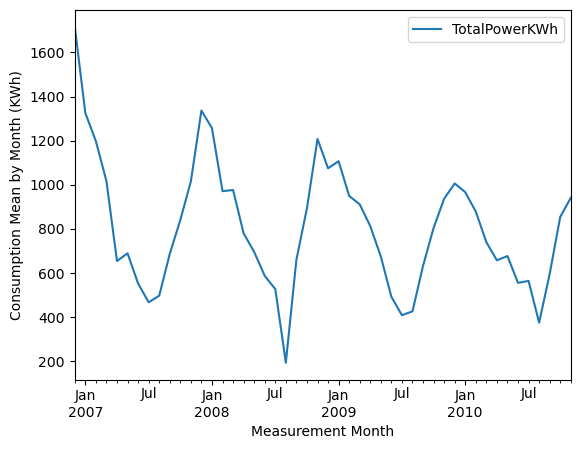

In [ ]:
energy_gp.plot()
plt.xlabel('Measurement Month')
plt.ylabel('Consumption Mean by Month (KWh)')

In [ ]:
y_hist, y_future= train_test_split(energy_gp, shuffle=False)

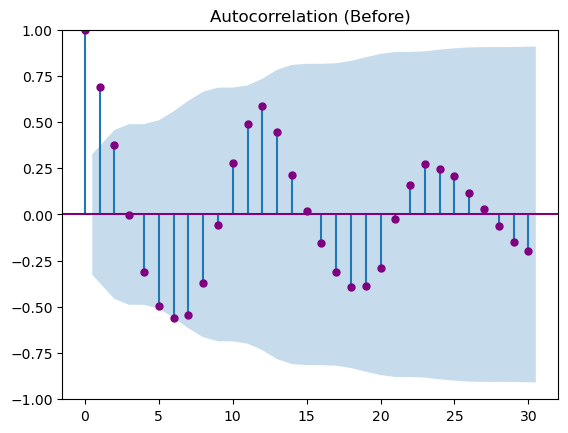

In [ ]:
tsaplots.plot_acf(y_hist, lags = 30, color="purple");
plt.title('Autocorrelation (Before)')
plt.show()

### Plot ACF PACF

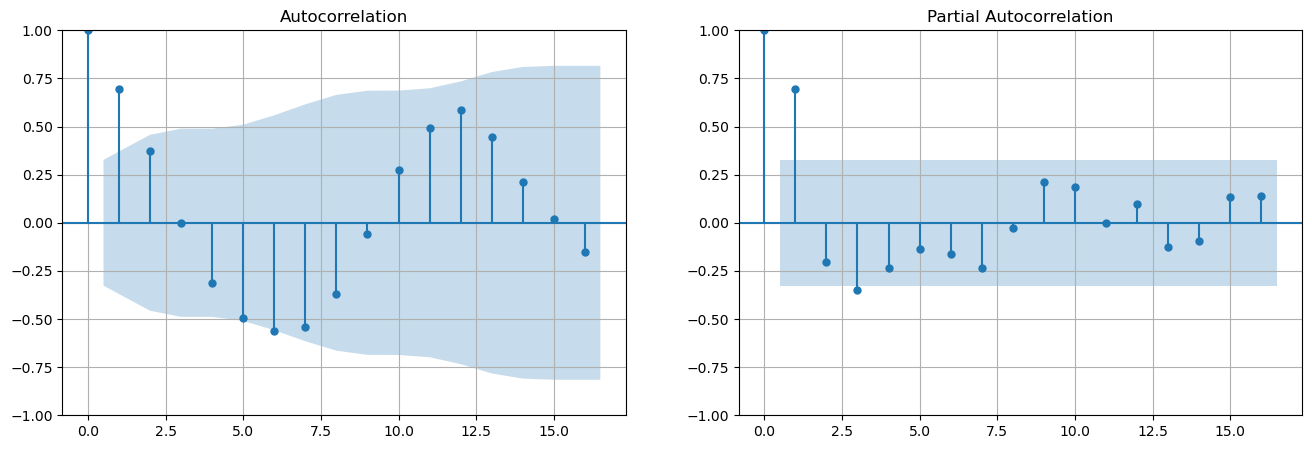

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
tsaplots.plot_acf(y_hist, ax = ax[0]);
ax[0].grid()
tsaplots.plot_pacf(y_hist, ax = ax[1], method = 'ywm');
ax[1].grid()

### ARIMA Forecast

#### Making data stationary

In [ ]:
y_hist_log = np.log(y_hist).diff().dropna()
y_future_log = np.log(y_future).diff().dropna()

<Axes: xlabel='Date'>

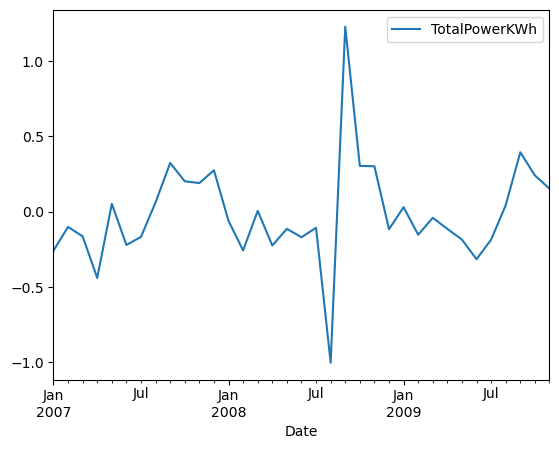

In [ ]:
y_hist_log.plot()

#### Plotting autocorrelation

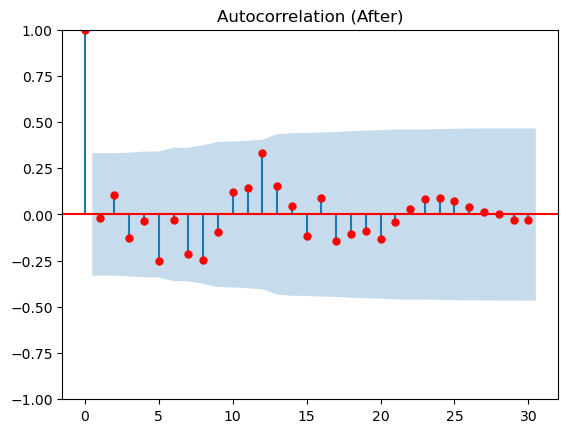

In [ ]:
tsaplots.plot_acf(y_hist_log,lags=30, color="red")
plt.title('Autocorrelation (After)')
plt.show()

#### Fuller Method

In [ ]:
fuller = adfuller(y_hist_log)
fuller

(-4.454794002664581,
 0.00023712542616074155,
 10,
 24,
 {'1%': -3.7377092158564813,
  '5%': -2.9922162731481485,
  '10%': -2.635746736111111},
 18.981397061290714)

#### Grid search hyperparams

In [ ]:
%%time
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
pdq_combinations = list(itertools.product(p_values, d_values, q_values))
best_aic = float("inf")
best_order = None
best_model = None
for order in pdq_combinations:
    try:
        model = ARIMA(y_hist_log, order=order)
        model_fit = model.fit()
        #print(f'AIC: {model_fit.aic}, Order: {order}')
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = order
            best_model = model_fit
    except Exception as e:
        print(f"Error fitting ARIMA model with order {order}")
print(f"Optimal ARIMA order: {best_order}")
print("AIC: ", best_aic)
print("BIC: ", best_model.bic)

Optimal ARIMA order: (3, 0, 4)
AIC:  17.09098987063328
BIC:  31.089122424038003
CPU times: total: 1min 6s
Wall time: 9.7 s


#### Arima Fit and Forecast

In [ ]:
%%time
arma = ARIMA(y_hist_log['TotalPowerKWh'], order = best_order).fit()
forecast = arma.forecast(steps = len(y_future))

CPU times: total: 750 ms
Wall time: 150 ms


In [ ]:
forecast = forecast.to_frame().rename(columns={'predicted_mean' : 'TotalPowerKWh'})
forecast.loc['2009-12-31'] = np.log(y_future.loc['2009-12-31']) 
forecast = np.exp(forecast.cumsum())

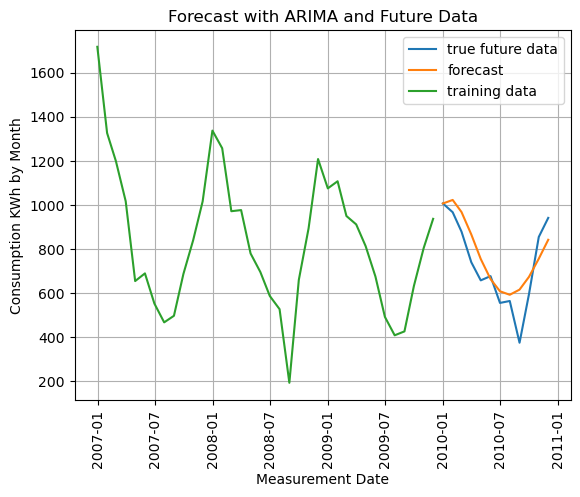

In [ ]:
plt.plot(y_future, label = 'true future data')
plt.plot(forecast, label = 'forecast')
plt.plot(y_hist, label = 'training data')
plt.legend()
plt.xlabel('Measurement Date')
plt.ylabel('Consumption KWh by Month')
plt.title('Forecast with ARIMA and Future Data')
plt.xticks(rotation = 90);
plt.grid();

#### Prediction Error

In [ ]:
pred_error = y_future - forecast
mae = np.abs(pred_error).mean()
rmse = np.sqrt((pred_error**2).mean())
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: TotalPowerKWh    81.540518
dtype: float64
RMSE: TotalPowerKWh    101.525687
dtype: float64


### SARIMAX Forecast

#### Making data stationary

In [ ]:
y_hist_log = np.log(y_hist).diff().dropna()
y_future_log = np.log(y_future).diff().dropna()

<Axes: xlabel='Date'>

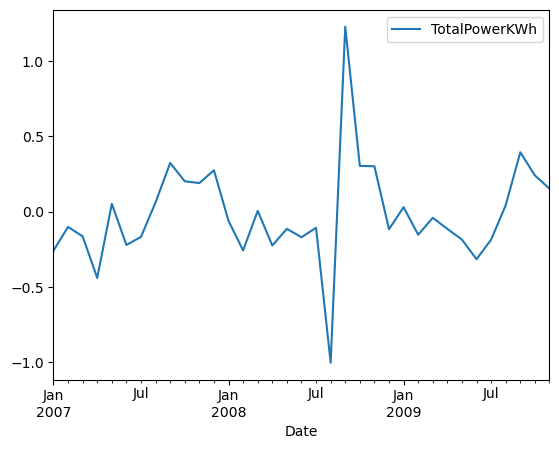

In [ ]:
y_hist_log.plot()

#### Plotting autocorrelation

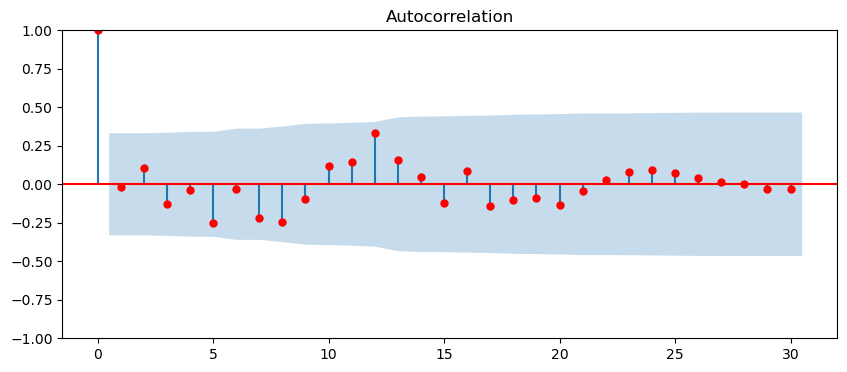

In [ ]:
_, ax = plt.subplots(figsize=(10,4))
tsaplots.plot_acf(y_hist_log,lags=30, ax=ax, color="red")
plt.show()

#### Fuller Method

In [ ]:
fuller = adfuller(y_hist_log)
fuller

(-4.454794002664581,
 0.00023712542616074155,
 10,
 24,
 {'1%': -3.7377092158564813,
  '5%': -2.9922162731481485,
  '10%': -2.635746736111111},
 18.981397061290714)

#### Grid search hyperparams

In [ ]:
%%time
seasonal_order = pm.auto_arima(y_hist_log['TotalPowerKWh'], seasonal=True, m=12)
display(seasonal_order.seasonal_order)
seasonal_order.order

(2, 0, 0, 12)

CPU times: total: 46.1 s
Wall time: 6.7 s


(1, 0, 1)

#### Arima Fit and Forecast

In [ ]:
%%time
order = seasonal_order.order
seasonal_order = seasonal_order.seasonal_order # Estacionalidad mensual
sarma = SARIMAX(y_hist_log['TotalPowerKWh'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False).fit()
forecast = sarma.forecast(steps = len(y_future))
sarma.aic

CPU times: total: 797 ms
Wall time: 115 ms


-9.690079243381938

In [ ]:
forecast = forecast.to_frame().rename(columns={'predicted_mean' : 'TotalPowerKWh'})
forecast.loc['2009-12-31'] = np.log(y_future.loc['2009-12-31']) 
forecast = np.exp(forecast.cumsum())

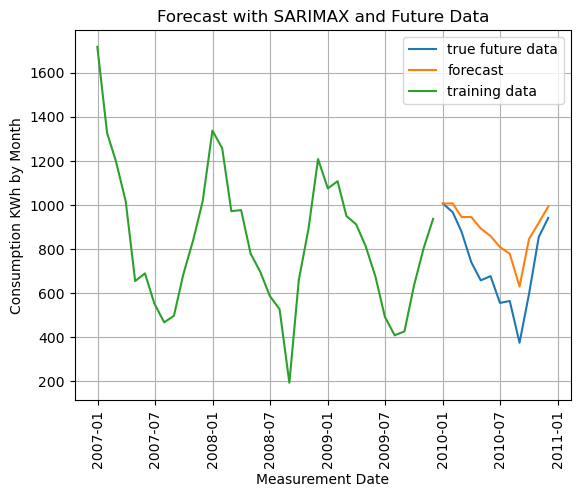

In [ ]:
plt.plot(y_future, label = 'true future data')
plt.plot(forecast, label = 'forecast')
plt.plot(y_hist, label = 'training data')
plt.legend()
plt.xlabel('Measurement Date')
plt.ylabel('Consumption KWh by Month')
plt.title('Forecast with SARIMAX and Future Data')
plt.xticks(rotation = 90);
plt.grid();

#### Prediction Error

In [ ]:
pred_error = y_future - forecast
mae = np.abs(pred_error).mean()
rmse = np.sqrt((pred_error**2).mean())
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: TotalPowerKWh    151.22507
dtype: float64
RMSE: TotalPowerKWh    177.91736
dtype: float64
